# 02_NFCS_Data_Cleaning

---

## Objetivo
Aplicar la limpieza final al conjunto de datos NFCS 2021, partiendo del archivo prelimpio generado en el EDA. Se imputan valores faltantes, se controlan outliers y se deja el dataset listo para tareas de modelado.

## Entradas (Inputs)
- `data/processed/final/NFCS_2021_EDA_clean.csv`
- `artifacts/final/NFCS_2021_EDA_decisions.json`

## Salidas (Outputs)
- `data/processed/final/NFCS_2021_final_clean.csv`
- `artifacts/final/NFCS_2021_final_clean_decisions.json`

---

## Resumen Ejecutivo
- **Técnicas empleadas:**  
  - Análisis de proporción de missing (drop de columnas > 30 %).  
  - Imputación de variables de escala con mediana + winsorización al 1 %.  
  - Imputación de variables categóricas con la moda.  
- **Resultados clave:**  
  - Se eliminaron solo 3 columnas con alta proporción de missing: `B20`, `B6` y `B34`.  
  - Se imputaron con éxito todas las variables restantes (numéricas y categóricas).  
  - Tras la limpieza, el dataset final (2824 × 92) no presenta ningún valor faltante ni atípicos extremos.  

## 1. Librerías, configuración y cargar desde Google drive

In [1]:
import sys
import os
from pathlib import Path

# 1. Añadir la raíz del proyecto al path
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize



# 3. Importar las rutas necesarias desde el archivo de configuración
from config import FINAL_PROCESSED_DATA_DIR, FINAL_ARTIFACTS_DIR

# Configuración de pandas y matplotlib
plt.style.use("default")
plt.rcParams['figure.figsize'] = (10, 4)
pd.options.display.max_columns = 100

# El input es el output "final" del notebook EDA anterior
input_csv_path = FINAL_PROCESSED_DATA_DIR / 'NFCS_2021_EDA_clean.csv'

# Las salidas de este notebook también son "finales"
output_csv_path = FINAL_PROCESSED_DATA_DIR / 'NFCS_2021_final_clean.csv'
output_audit_path = FINAL_ARTIFACTS_DIR / 'NFCS_2021_final_clean_decisions.json'

# Cargar el DataFrame
df = pd.read_csv(input_csv_path)
print(f"Dimensiones iniciales del dataset: {df.shape}")
df.head()


Módulo de configuración cargado y estructura de carpetas asegurada.
Dimensiones iniciales del dataset: (2824, 95)


,NFCSID,A1,A2,A3,B2_1,B2_2,B2_3,B2_4,B2_5,B2_20,B2_23,B2_24,B30,B31,B3,B32,B4,B6,B20,B34,B10,B11,B35,B23,B24,B25,B26,C22_1,C22_2,C22_3,C22_4,C24,C25,C26,C30,C7,D1_1,D1_2,D2,D3,D21,D30,D31,E1_1,E5,E6,F30_1,F30_2,F30_3,F30_4,F30_5,F30_6,F30_7,F30_8,F30_9,F30_10,F30_11,F30_12,F31_1,F31_2,F31_3,F31_4,F31_5,F31_6,F31_7,F31_8,F31_9,F31_10,F31_11,G1,G2,G30_1,G30_2,G30_3,G30_4,G30_5,G30_6,G31,G4,G5,G6,G7,G21,G8,G11,G12,G13,H31,WGT1,S_Gender2,S_Age,S_Ethnicity,S_Education,S_Income,B4_log
0,2.021010e+09,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,4.0,1.0,4.0,2.0,8.0,2.0,NaN,2.0,2.0,1.0,2.0,1.0,4.0,1.0,1.0,1.0,2.0,3.0,2.0,2.0,7.0,1.0,1.0,1.0,9.0,7.0,5.0,2.0,1.0,3.0,5.0,7.0,3.0,4.0,2.0,3.0,2.0,3.0,3.0,2.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,9.0,5.0,1.0,3.0,1.0,1.0,2.0,3.0,8.0,1.0,2.0,2.0,1.0,2.0,1.0,3.0,2.0,3.0,1.0,1.736049,2.0,1.0,1.0,2.0,3.0,2.197225
1,2.021010e+09,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,5.0,1.0,3.0,1.0,5.0,2.0,NaN,2.0,3.0,2.0,2.0,1.0,3.0,2.0,NaN,1.0,2.0,3.0,3.0,3.0,10.0,2.0,2.0,2.0,7.0,6.0,3.0,2.0,1.0,3.0,2.0,7.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,4.0,2.0,3.0,2.0,1.0,1.0,1.0,10.0,2.0,1.0,2.0,2.0,1.0,5.0,2.0,3.0,3.0,1.0,0.547490,2.0,3.0,1.0,2.0,1.0,1.791759
2,2.021010e+09,1.0,1.0,1.0,1.0,1.0,1.0,NaN,2.0,2.0,2.0,2.0,5.0,1.0,3.0,2.0,7.0,NaN,NaN,1.0,3.0,2.0,2.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,3.0,7.0,NaN,2.0,NaN,8.0,6.0,3.0,2.0,1.0,3.0,3.0,7.0,3.0,3.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,6.0,5.0,2.0,3.0,2.0,1.0,2.0,2.0,5.0,1.0,2.0,2.0,1.0,2.0,1.0,3.0,2.0,4.0,2.0,0.547490,1.0,3.0,1.0,2.0,2.0,2.079442
3,2.021010e+09,2.0,2.0,1.0,2.0,2.0,NaN,NaN,NaN,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,3.0,1.0,2.0,1.0,4.0,2.0,1.0,NaN,1.0,3.0,3.0,2.0,NaN,NaN,NaN,2.0,6.0,6.0,3.0,2.0,3.0,1.0,5.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7.0,5.0,2.0,2.0,1.0,NaN,NaN,2.0,7.0,NaN,2.0,2.0,1.0,1.0,1.0,3.0,2.0,3.0,2.0,1.638773,1.0,2.0,2.0,1.0,1.0,1.098612
4,2.021010e+09,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,5.0,1.0,2.0,2.0,6.0,NaN,NaN,NaN,3.0,1.0,2.0,1.0,5.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,8.0,2.0,2.0,2.0,7.0,1.0,3.0,3.0,3.0,3.0,2.0,7.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,6.0,2.0,2.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,3.0,3.0,2.0,2.0,0.870537,1.0,3.0,1.0,1.0,1.0,1.945910


## 2. Diagnóstico de valores faltantes

### Detección de columnas con alta proporción de valores faltantes

En esta sección analizamos todas las variables del dataset para identificar aquellas con una proporción elevada de valores ausentes (`NaN`), **independientemente de si aplican a toda la muestra o solo a subgrupos específicos**.

Esta etapa complementa al EDA inicial, que se centró en describir las variables clave para el modelado, y no incluyó un análisis exhaustivo de completitud en todas las columnas del dataset.

#### Justificación metodológica

Variables como `B6`, `B20` y `B34` **no fueron detectadas previamente como problemáticas** porque:

- No se encontraban en los subconjuntos de variables analizados durante el EDA.
- Aplican exclusivamente a subgrupos del cuestionario (por ejemplo, quienes tienen cuentas de inversión).
- El análisis de valores faltantes en el EDA fue temático y enfocado, como es habitual en fases exploratorias.

Ahora corregimos esta omisión y evaluamos la completitud global.


In [2]:
# Calcular % de valores faltantes por columna
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
missing_pct[missing_pct > 30]

B20    92.634561
B6     76.451841
B34    67.953258
dtype: float64

#### Decisión de limpieza

Las siguientes variables tienen más del 30 % de valores faltantes y **no serán incluidas en el modelo general**, ya que:

- No aportan información sistemática a toda la muestra.
- Podrían introducir sesgo si se imputan fuera de su subgrupo lógico.

Si en el futuro se entrena un modelo específico para inversores activos, estas variables podrían reconsiderarse.

Procedemos a eliminarlas.


In [3]:
# Asegurar que la variable existe
if 'COLUMNS_TO_DROP' not in globals():
    COLUMNS_TO_DROP = []

# Calcular % de valores faltantes por columna
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
high_missing = missing_pct[missing_pct > 30].index.tolist()

# Las que aún no han sido eliminadas
new_to_drop = [col for col in high_missing if col in df.columns and col not in COLUMNS_TO_DROP]

print("Columnas adicionales a eliminar por alta proporción de missing:")
print(new_to_drop)

# Eliminar del DataFrame
df.drop(columns=new_to_drop, inplace=True)
COLUMNS_TO_DROP += new_to_drop

Columnas adicionales a eliminar por alta proporción de missing:
['B20', 'B6', 'B34']


### Resto de columnas con valores faltantes

In [4]:
# Mostrar las variables con entre 10% y 30% de valores faltantes

# Calculate remaining missing values *after* dropping high-missing columns
remaining_missing = df.isna().mean().sort_values(ascending=False)
remaining_missing = remaining_missing[remaining_missing > 0]

mid_missing = remaining_missing[(remaining_missing >= 0.10) & (remaining_missing <= 0.30)].sort_values(ascending=False)

print("Variables con entre 10% y 30% de valores faltantes:")
mid_missing

Variables con entre 10% y 30% de valores faltantes:


B26    0.259561
C25    0.216360
B24    0.212110
B25    0.135269
G21    0.113314
dtype: float64

#### Variables con entre 10 % y 30 % de valores faltantes

Estas variables tienen un porcentaje moderado de valores faltantes. Se analizan caso por caso para decidir su tratamiento.

| Variable | % Missing | Descripción                                                                 | Interpretación y acción sugerida                                                                 |
|----------|-----------|------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **B26**  | 25.96 %   | ¿Quién toma las decisiones de inversión?                                     | Aplicable solo a subgrupos (inversores activos). Se conserva sin imputar para análisis segmentado. |
| **C25**  | 21.64 %   | ¿Qué porcentaje de activos líquidos tiene invertido?                         | Variable escalar importante. Se imputará la mediana y se aplicará winsorización.                 |
| **B24**  | 21.21 %   | ¿Cuál es su nivel de confianza en la toma de decisiones financieras?         | Escala clave para modelar tolerancia al riesgo. Imputar mediana + winsorizar.                   |
| **B25**  | 13.53 %   | ¿Cuál es su horizonte de inversión?                                          | Variable categórica relevante. Se imputará la moda.                                              |
| **G21**  | 11.33 %   | Nivel de conocimiento financiero percibido (auto-reporte del encuestado)     | Escala percibida útil. Se imputará mediana + winsorización si se usa como numérica.             |


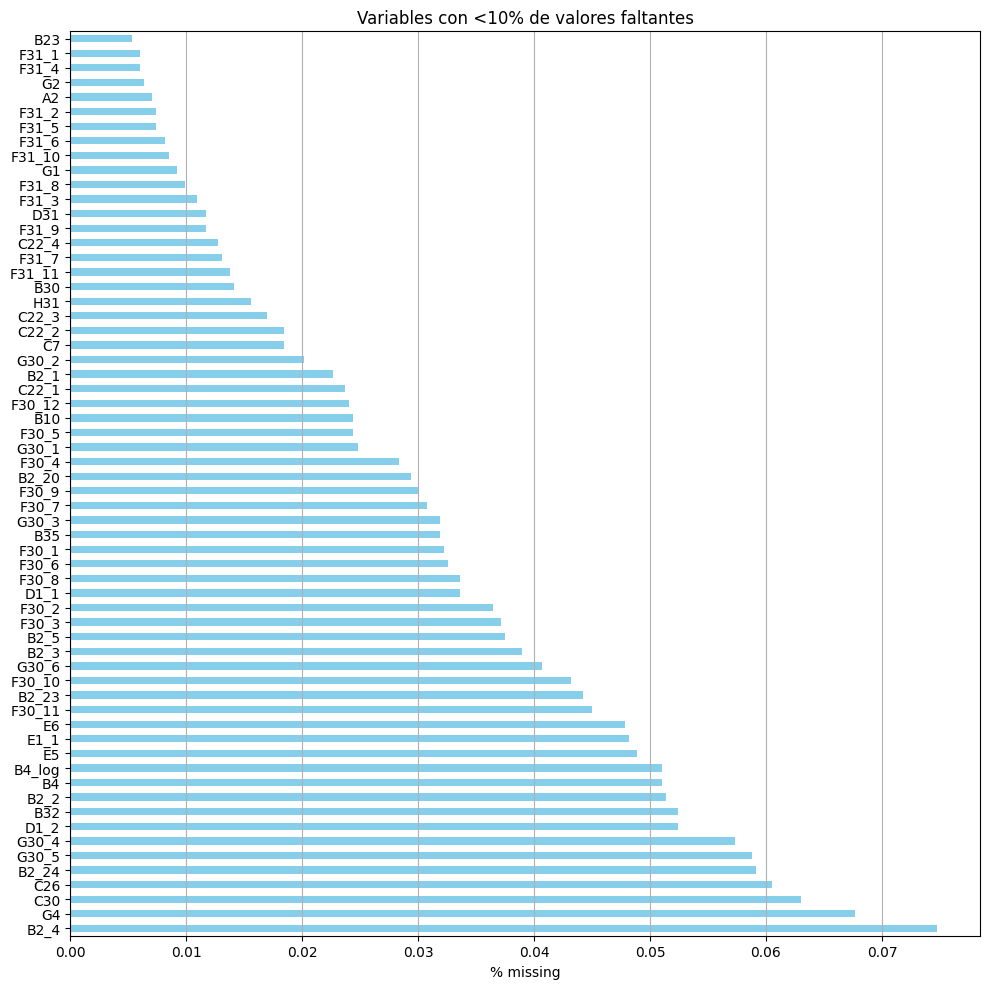

In [5]:
# Calcular valores faltantes globales
remaining_missing = df.isna().mean().sort_values(ascending=False)
remaining_missing = remaining_missing[remaining_missing > 0]

# Variables con menos del 10% de missing
low_missing = remaining_missing[remaining_missing < 0.10].sort_values(ascending=False)

# Visualización
plt.figure(figsize=(10, 10))
low_missing.plot(kind='barh', color='skyblue')
plt.title("Variables con <10% de valores faltantes")
plt.xlabel("% missing")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

#### Variables con menos del 10 % de valores faltantes (agrupadas)

A continuación se presenta un resumen de las variables con baja proporción de `NaN` (menos del 10 %), agrupadas por bloques temáticos para facilitar su interpretación. Se incluye una breve descripción y la acción recomendada.

| Grupo / Variable                       | Variables incluidas                            | Descripción                                                                                 | Acción sugerida                          |
|----------------------------------------|------------------------------------------------|---------------------------------------------------------------------------------------------|-------------------------------------------|
| **F30_x (actitudes financieras)**       | F30_1 a F30_12                                 | Ítems Likert sobre hábitos financieros: planificación, gasto, control de presupuesto        | Imputar mediana + winsorizar              |
| **F31_x (creencias sobre inversión)**  | F31_1 a F31_7                                  | Ítems Likert sobre creencias de mercado: volatilidad, expectativas, horizonte temporal      | Imputar mediana + winsorizar              |
| **Q1–Q3 (conocimiento financiero)**     | Q1, Q2, Q3                                     | Preguntas de verdadero/falso sobre conocimiento objetivo                                    | Imputar moda si es relevante              |
| **C22_4**                               | C22_4                                          | Ítem Likert: "Me interesa invertir por mi cuenta"                                           | Imputar mediana                           |
| **C30**                                 | C30                                            | Ítem Likert: "Tengo suficiente información para invertir"                                   | Imputar mediana                           |
| **G4**                                  | G4                                             | Pregunta sobre percepción de riesgo (pérdida al invertir)                                   | Imputar moda                              |
| **B2_4**                                | B2_4                                           | Uso de producto financiero específico (aplica a submuestra)                                 | Imputar moda o marcar como subgrupo       |
| **B23**                                 | B23                                            | ¿Tiene cuenta de inversión conjunta?                                                        | Imputar moda                              |
| **H31**                                 | H31                                            | Nivel de estrés financiero (Likert)                                                         | Imputar mediana                           |


## 3. Imputación de variables de escala

En esta fase del proceso de limpieza hemos tratado las variables de tipo **escala numérica** (por ejemplo, ítems tipo Likert, porcentajes o indicadores continuos) que aún presentaban valores faltantes (`NaN`).


### 3.1 Identificar columnas de escala que siguen con nulos

Se generó una lista automática de columnas numéricas (`dtype = float64 o int64`) que todavía contenían valores nulos.  
Este paso es importante para asegurarnos de no omitir variables clave que afectan al modelado si se dejan incompletas.

In [6]:
# Lista de variables escalares con missing a tratar (excluyendo especiales)
excluir = ['B10', 'B2_4', 'B23', 'B25', 'G4', 'B26', 'B4_log']

# Identificar variables numéricas (escala) que aún tienen valores faltantes
numeric_cols = df.select_dtypes(include=np.number).columns
scale_vars_missing = [col for col in numeric_cols if df[col].isna().any()]

scale_vars_clean = [col for col in scale_vars_missing if col not in excluir]

print("Variables de escala numérica a imputar (mediana + winsorización):")
print(scale_vars_clean)

# Imputación y winsorización
from scipy.stats.mstats import winsorize

for col in scale_vars_clean:
    mediana = df[col].median()
    df[col] = df[col].fillna(mediana)
    # Ensure that the winsorize function is imported correctly
    # The import is already in the original code block, so no need to add it again here if the original block is used.
    df[col] = winsorize(df[col], limits=[0.01, 0.01])

print("Imputación completada.")

Variables de escala numérica a imputar (mediana + winsorización):
['A2', 'B2_1', 'B2_2', 'B2_3', 'B2_5', 'B2_20', 'B2_23', 'B2_24', 'B30', 'B32', 'B4', 'B35', 'B24', 'C22_1', 'C22_2', 'C22_3', 'C22_4', 'C25', 'C26', 'C30', 'C7', 'D1_1', 'D1_2', 'D31', 'E1_1', 'E5', 'E6', 'F30_1', 'F30_2', 'F30_3', 'F30_4', 'F30_5', 'F30_6', 'F30_7', 'F30_8', 'F30_9', 'F30_10', 'F30_11', 'F30_12', 'F31_1', 'F31_2', 'F31_3', 'F31_4', 'F31_5', 'F31_6', 'F31_7', 'F31_8', 'F31_9', 'F31_10', 'F31_11', 'G1', 'G2', 'G30_1', 'G30_2', 'G30_3', 'G30_4', 'G30_5', 'G30_6', 'G21', 'H31']
Imputación completada.


### 3.2 Imputar mediana + winsorización

In [7]:
import warnings

warnings.filterwarnings('ignore', message=".*'partition' will ignore the 'mask'.*")

# Imputamos la mediana en cada variable de escala con missing y controlamos outliers con winsorización al 1%–99%
for col in scale_vars_missing:
    mediana = df[col].median()
    # Cambiamos inplace=True por asignación directa
    df[col] = df[col].fillna(mediana)
    # Winsorización
    df[col] = winsorize(df[col], limits=[0.01, 0.01])

print("Imputación de mediana y winsorización completada")

Imputación de mediana y winsorización completada


1. **Imputación por mediana**:  
   Se ha calculado la mediana de cada variable con valores faltantes y se han reemplazado los `NaN` por ese valor.  
   - Esto es útil porque la mediana es resistente a valores extremos y mantiene la forma central de la distribución.

2. **Winsorización al 1.º y 99.º percentil**:  
   Después de imputar, se ha aplicado un recorte (winsorize) para limitar el impacto de **outliers extremos**, transformando cualquier valor fuera del percentil 1–99 a los valores de corte.  
   - Esto ayuda a estabilizar la varianza y evitar que valores atípicos sesguen los modelos.

- Este enfoque conserva el máximo número de registros sin introducir sesgos artificiales.
- Al mismo tiempo, evita que valores extremos desproporcionados (por errores o comportamientos atípicos) influyan en el aprendizaje del modelo.

## 4. Imputación de variables categóricas (<10 % missing)

En este paso tratamos aquellas variables de tipo **categórico** (por ejemplo: respuestas tipo opción múltiple, codificadas como texto o números) que tienen un bajo porcentaje de valores ausentes (menos del 10 %).


In [8]:
# Identificar variables categóricas con <10% de valores faltantes
cat_vars = df.select_dtypes(include='object').columns

for col in cat_vars:
    missing_ratio = df[col].isna().mean()
    if 0 < missing_ratio < 0.10:
        moda = df[col].mode(dropna=True)
        if not moda.empty:
            df[col] = df[col].fillna(moda[0])
            print(f" Imputada la moda en: {col} ({round(missing_ratio * 100, 2)}%)")

1. Se identifican las columnas **categóricas** (`dtype = object`) que presentan algún porcentaje de `NaN`.
2. Para cada una, si el porcentaje de valores faltantes es **menor al 10 %**, se imputan usando la **moda** (el valor más frecuente).
3. Este tipo de imputación es adecuada porque:
   - Preserva la estructura de distribución de la variable.
   - Minimiza la distorsión de categorías cuando el `NaN` es poco frecuente.
   - Es rápida, simple y robusta.

## 5. Revisión final: valores faltantes tras limpieza

Se ha realizado una revisión completa del DataFrame tras aplicar los procesos de imputación en variables escalares y categóricas. Los resultados muestran que el dataset ya no contiene valores faltantes (`NaN`) en ninguna de sus columnas.

In [9]:
# Recalcular missing por columna
missing_pct = df.isna().mean() * 100
high_missing = missing_pct[missing_pct > 30].index.tolist()

# Eliminar columnas con más de 30% missing
df.drop(columns=high_missing, inplace=True)

# Guardar registro si estás construyendo 'decisions'
if 'COLUMNS_TO_DROP' in globals():
    COLUMNS_TO_DROP += high_missing
else:
    COLUMNS_TO_DROP = high_missing

In [10]:
# Revisión final: resumen de valores faltantes tras imputaciones
missing_final = df.isna().mean().sort_values(ascending=False) * 100
missing_final = missing_final[missing_final > 0]

# Separar por tipo de variable
missing_numeric = df.select_dtypes(include=['float64', 'int64']).isna().mean() * 100
missing_categoric = df.select_dtypes(include='object').isna().mean() * 100

missing_numeric = missing_numeric[missing_numeric > 0].sort_values(ascending=False)
missing_categoric = missing_categoric[missing_categoric > 0].sort_values(ascending=False)

# Resumen general
print(" Resumen de valores faltantes tras limpieza:")
print(f" Total variables con missing: {len(missing_final)}")
print(f" Variables numéricas con missing: {len(missing_numeric)}")
print(f" Variables categóricas con missing: {len(missing_categoric)}")
print(f" Porcentaje máximo de missing restante: {round(missing_final.max(), 2)}%")

# Mostrar top 10 columnas con más missing (si quedan)
if not missing_final.empty:
    print("\n Top 10 columnas con más missing aún presentes:")
    display(missing_final.head(10))
else:
    print("\n No quedan columnas con valores faltantes.")

 Resumen de valores faltantes tras limpieza:
 Total variables con missing: 0
 Variables numéricas con missing: 0
 Variables categóricas con missing: 0
 Porcentaje máximo de missing restante: nan%

 No quedan columnas con valores faltantes.


- 🔹 **Total de variables con valores faltantes**: 0  
- 🔹 **Variables numéricas con missing**: 0  
- 🔹 **Variables categóricas con missing**: 0  
- 🔹 **Porcentaje máximo de missing restante**: 0 %

**Conclusión**

El dataset está **completamente limpio y preparado** para análisis exploratorios avanzados, ingeniería de características o entrenamiento de modelos predictivos.

Todas las decisiones de imputación fueron realizadas con criterios coherentes (mediana para escalares, moda para categóricas), y se han documentado a lo largo del proceso.

## 6. Guardar dataset final y auditoría

In [11]:
import json
from pathlib import Path

# La ruta de entrada del JSON de decisiones también debe ser la final.
input_audit_path = FINAL_ARTIFACTS_DIR / 'NFCS_2021_EDA_decisions.json'

with open(input_audit_path, "r", encoding="utf-8") as f:
    decisions = json.load(f)

print("Auditoría EDA cargada correctamente")

# Añadir datos nuevos al registro
decisions["final_cleaning_shape"] = df.shape  # Dimensiones tras la limpieza final

# 1. Guardar dataset final limpio
df.to_csv(output_csv_path, index=False)

# 2. Guardar auditoría actualizada
with open(output_audit_path, 'w', encoding='utf-8') as f:
    json.dump(decisions, f, indent=2, ensure_ascii=False)

print(f" Dataset final guardado en: {output_csv_path}")
print(f" Auditoría final guardada en: {output_audit_path}")

Auditoría EDA cargada correctamente
 Dataset final guardado en: C:\Users\Antonio\Documents\1. Proyectos\DataScience\TFM-AntonioEsquinas\data\processed\final\NFCS_2021_final_clean.csv
 Auditoría final guardada en: C:\Users\Antonio\Documents\1. Proyectos\DataScience\TFM-AntonioEsquinas\artifacts\final\NFCS_2021_final_clean_decisions.json


## Cierre del proceso de limpieza

- Se eliminaron variables con alta proporción de valores faltantes o irrelevantes.
- Se imputaron variables escalares con **mediana** y se aplicó **winsorización** para tratar outliers.
- Se imputaron variables categóricas con < 10 % de missing usando la **moda**.
- El dataset resultante **no contiene valores faltantes** y mantiene la estructura necesaria para análisis y model


## Conclusiones Finales
- Solo las variables `B20`, `B6` y `B34` superaban el umbral del 30 % de missing y fueron descartadas.  
- Las variables de escala con valores faltantes fueron completadas con su mediana y winsorizadas al 1 % para limitar outliers extremos, asegurando distribuciones más robustas.  
- Las variables categóricas restantes se imputaron con la moda, preservando la frecuencia de las categorías originales.  
- El proceso de auditoría quedó registrado en un archivo JSON, garantizando trazabilidad y reproducibilidad de cada decisión de limpieza.  
- El dataset resultante, con 2824 observaciones y 92 variables limpias, está listo para fases de análisis exploratorio más profundas o modelado predictivo.